In [1]:
import logging
from argparse import ArgumentParser
from multiprocessing import Pool
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from laptrack import LapTrack
from skimage.measure import regionprops_table
from skimage.transform import downscale_local_mean

logging.basicConfig(level="INFO")



C:\Users\Nikon\Desktop\Code\Toettchlab-FBC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_cellpose(infile, args):
    from cellpose import models
    from cellpose.io import imread

    model = models.CellposeModel(gpu=True, pretrained_model=args.model)

    stack = imread(infile)

    stack = [frame.astype(np.uint16) for frame in stack]

    if len(args.cellpose_norm) == 2:
        normalize = {"lowhigh": [args.cellpose_norm[0], args.cellpose_norm[1]]}

    else:
        normalize = True

    masks, _flows, _styles = model.eval(stack, batch_size=8, normalize=normalize)

    masks = np.stack(masks, axis=0)

    return masks


def process_masks(masks):
    collect_spots = []

    for t, frame in enumerate(masks):
        props = regionprops_table(frame, properties=["label", "area", "centroid"])

        df = pd.DataFrame(props)
        df["frame"] = t
        df = df.rename(columns={"centroid-0": "px_y", "centroid-1": "px_x"})

        print(df)

        collect_spots.append(df)

    spots_df = pd.concat([s for s in collect_spots], ignore_index=True)

    return spots_df


def track_spots(spots_df):
    max_distance = 20

    lt = LapTrack(
        metric="sqeuclidean",
        # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
        splitting_metric="sqeuclidean",
        merging_metric="sqeuclidean",
        gap_closing_metric="sqeuclidean",
        # the square of the cutoff distance for the "sqeuclidean" metric
        cutoff=max_distance**2,
        splitting_cutoff=False,  # or False for non-splitting case
        merging_cutoff=False,  # or False for non-merging case
        gap_closing_cutoff=max_distance**2,
        gap_closing_max_frame_count=2,
    )

    track_df, _split_df, _merge_df = lt.predict_dataframe(
        spots_df,
        coordinate_cols=[
            "px_x",
            "px_y",
        ],  # the column names for the coordinates
        frame_col="frame",  # the column name for the frame (default "frame")
        only_coordinate_cols=False,
    )

    track_df = track_df.rename(columns={"frame_y": "frame"})

    return track_df

def process_file(infile, in_dir, args):
    masks_dir = in_dir / "masks"
    tracks_dir = in_dir / "tracks"

    masks_outfile = masks_dir / f"{infile.stem}_masks.tif"
    tracks_outfile = tracks_dir / f"{infile.stem}_tracks.csv"

    cellpose_masks = run_cellpose(str(infile), args)
    tifffile.imwrite(
        masks_outfile,
        cellpose_masks.astype(np.uint16),
        imagej=True,
        metadata={"axes": "tyx"},
    )

    spots = process_masks(cellpose_masks)

    tracks = track_spots(spots)
    tracks.to_csv(tracks_outfile, index=False)

    return tracks

In [3]:
from types import SimpleNamespace

args = SimpleNamespace(
    dir = r"D:\Charlotte\E14 segment",  # the folder containing the tifs
    glob = "*.tif",  # segments all the .tif files in a directory
    cellpose_norm = [0, 1500], # lowest and highest pixel intensities
    model = "charlotte_e14_ktrT1_001"  # name of the cellpose model to load
)

segmenting and tracking file 0/1: CC_E14 KTR tissue nucleus 1


INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\Nikon\.cellpose\models\charlotte_e14_ktrT1_001
INFO:cellpose.io:reading tiff with 133 planes
INFO:cellpose.models:0%|          | 0/133 [00:00<?, ?it/s]
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image with (415, 615) HW
INFO:cellpose.transforms:processing grayscale image 

     label   area        px_y        px_x  frame
0        1  164.0    4.457317   19.378049      0
1        2  252.0    6.361111   48.202381      0
2        3  253.0    5.561265  187.529644      0
3        4  202.0    3.910891  234.024752      0
4        5  170.0    5.517647  269.170588      0
..     ...    ...         ...         ...    ...
156    157  176.0  409.710227   12.517045      0
157    158  130.0  410.546154  253.215385      0
158    159   63.0  411.587302  460.888889      0
159    160   98.0  411.489796  583.775510      0
160    161   90.0  411.888889  157.588889      0

[161 rows x 5 columns]
     label   area        px_y        px_x  frame
0        1  196.0    5.153061   17.561224      1
1        2  395.0    8.924051  185.250633      1
2        3  259.0    5.011583  230.281853      1
3        4  243.0    8.411523  270.958848      1
4        5  223.0    3.197309  309.829596      1
..     ...    ...         ...         ...    ...
150    151  234.0  403.059829  533.683761    

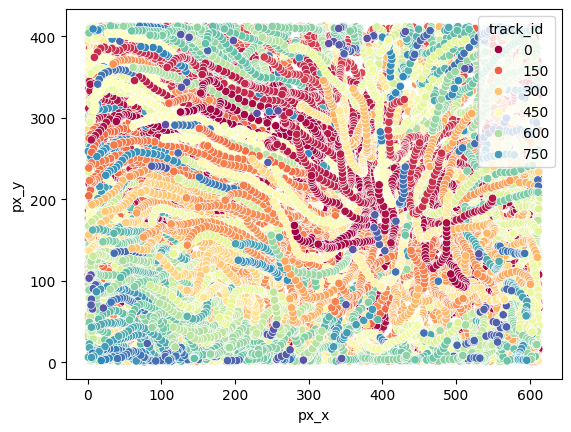

In [4]:

in_dir = Path(args.dir)

masks_dir = in_dir / "masks"
tracks_dir = in_dir / "tracks"

masks_dir.mkdir(exist_ok=True)
tracks_dir.mkdir(exist_ok=True)

files = list(in_dir.glob(args.glob))
shuffle(files)

for i, file in enumerate(files):
    print(f"segmenting and tracking file {i}/{len(files)}: {file.stem}")
    tracks = process_file(file, in_dir, args)

    import seaborn as sns

    sns.scatterplot(tracks, x="px_x", y="px_y", hue="track_id", palette="Spectral")
    plt.show()

